### Import all the Dependencies

In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')
from matplotlib.image import imread

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "PlantVillage_3"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

## Initializing, Exploring & Partioning the Dataset

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:



1:Training: Dataset to be used while training
2:Validation: Dataset to be tested against while training
3:Test: Dataset to be tested against after we trained a model

In [3]:
def get_data_partitions_tf(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = data.cardinality().numpy()
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = data.take(train_size)    
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

# Reading and Partitioning the Dataset

We create a Tensorflow Dataset Object and directly read it from the directory using image_dataset_from_directory and then split it using the function we created above

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  shuffle=True,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

10 ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# Displaying Some Images

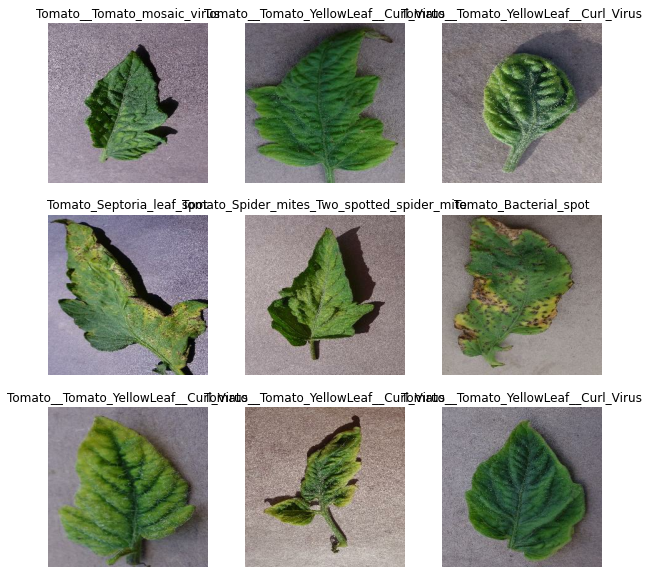

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Checking Batch Size

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


# Cache, Shuffle, and Prefetch the Dataset

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we are going to resize it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model.

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Checking what is the expected dimension order for channel

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

## Applying Data Augmentation to Train Dataset

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing

In [13]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

We used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
400/400 [==============================] - 111s 244ms/step - loss: 1.6772 - accuracy: 0.3985 - val_loss: 1.2587 - val_accuracy: 0.5612
Epoch 2/50
400/400 [==============================] - 63s 157ms/step - loss: 0.9607 - accuracy: 0.6674 - val_loss: 0.8269 - val_accuracy: 0.7262
Epoch 3/50
400/400 [==============================] - 63s 157ms/step - loss: 0.6707 - accuracy: 0.7623 - val_loss: 0.9497 - val_accuracy: 0.6969
Epoch 4/50
400/400 [==============================] - 65s 163ms/step - loss: 0.5102 - accuracy: 0.8165 - val_loss: 0.5000 - val_accuracy: 0.8188
Epoch 5/50
400/400 [==============================] - 65s 162ms/step - loss: 0.4379 - accuracy: 0.8465 - val_loss: 0.7757 - val_accuracy: 0.7588
Epoch 6/50
400/400 [==============================] - 64s 159ms/step - loss: 0.3807 - accuracy: 0.8679 - val_loss: 0.5461 - val_accuracy: 0.8156
Epoch 7/50
400/400 [==============================] - 68s 171ms/step - loss: 0.3376 - accuracy: 0.8793 - val_loss: 0.4665 - val_a

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
51/51 [==============================] - 23s 39ms/step - loss: 0.1427 - accuracy: 0.9534
Test Accuracy: 95.34%


## Plotting the Accuracy and Loss Curves

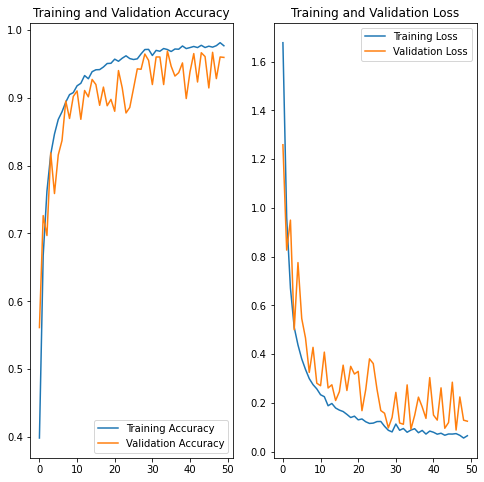

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Saving the Model

We append the model to the list of models as a new version

In [21]:
import os
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


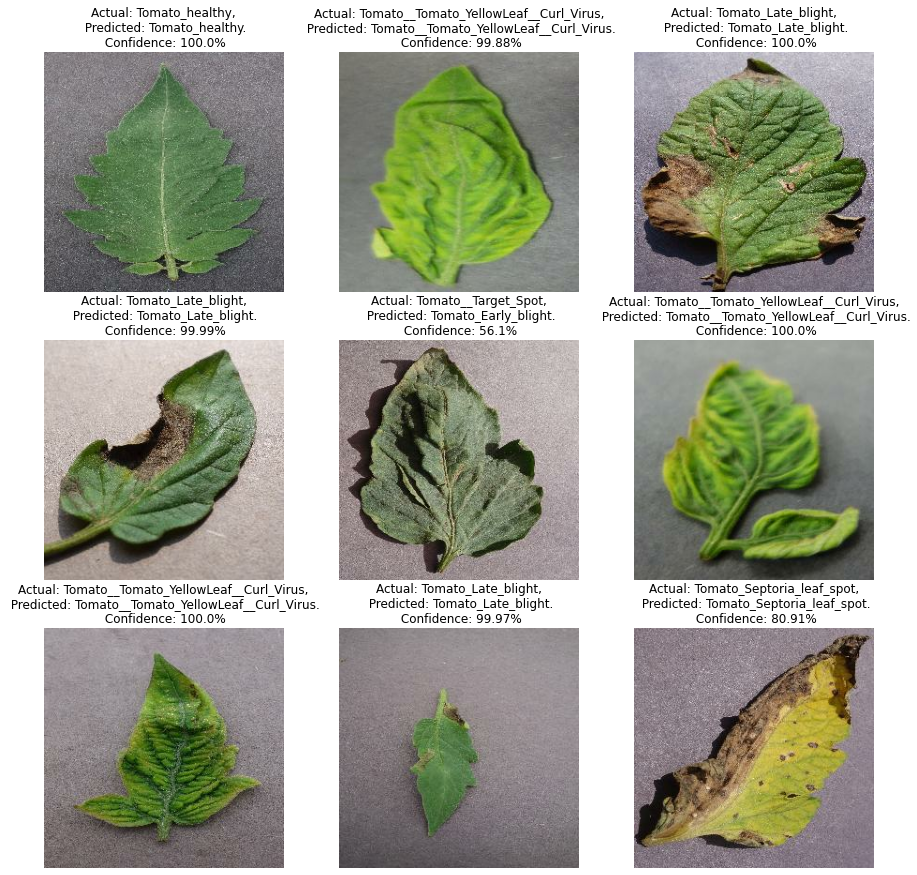

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [24]:
model.save("../Tomato.h5")